In [10]:
import numpy as np
import matplotlib.pyplot as plt

xmin = 2
xmax = 8

In [5]:
def continuous_sizes(N):
    """
    Create initial arrangement of N particles with random size distribution
    
    Inputs
    N       Number of particles
    
    Outputs
    config  Configuration
    """
    config = []
    for _ in range(N):
        r = 0.2 + 0.5*np.random.rand()
        config = add_particle(config, r, 1)
        
    return config

In [8]:
def add_particle(config, radius, mass):
    """
    Add a new particle to the configuration, accounting for relevant checks.
    
    Inputs
    config   List of [x, y, r, m] elements that each describe the position and size of a particle
    radius   Radius of particle
    mass     Mass of particle
    
    Outputs
    config   Configuration with new particle
    """
    # Chooses x and y from uniform distributions, x in [xmin, xmax] and y in [0, 10]
    y = np.random.chisquare(5,1)[0]
    x = xmin + (xmax - xmin)*np.random.rand()
    
    # While new position is not allowed, keep guessing
    while overlaps_box(config + [[x, y, radius, mass]]) or overlaps_particle(config +  [[x, y, radius, mass]]):
        y = np.random.chisquare(5,1)[0]
        x = xmin + (xmax - xmin)*np.random.rand()
        
    config.append([x, y, radius, mass])
    return config

In [2]:
def jump(config, particle):
    """ 
    Performs a jump for particle by finding random x and y step distances scaled by the largest nearest neighbour 
    distance. Then checks if move improves the energy and is physically allowed, then accepts the move and returns or 
    repeats until it finds an acceptable move. 
    
    Inputs
    particle         Index of the particle to perform a jump for
    config           List of [x, y, r, m] elements that each describe the position and size of a particle
    
    Outputs
    new_config       Returns a new configuration that is guaranteed to be physically allowed and improves the energy
    n                Number of attempted jumps
    """
    n = 0
    
    nndist = nn_dist(config, particle)
    
    # Break early and avoid unnecessary computations after 10 attempts
    while n < 10:
        
        new_config = np.copy(config)
        
        # Generate random x and y steps
        mass = config[particle][3]
        pot = potential(config)
        step_x = np.random.randn()*nndist/np.sqrt(2)
        step_y = np.random.randn()*nndist/np.sqrt(2)

        # Implement move and calculate new potential
        new_config[particle][0] += step_x
        new_config[particle][1] += step_y
        new_pot = potential(new_config)
        
        n += 1
        
        # Continue searching if jump is unphysical or energetically unfavourable
        if overlaps(new_config, particle):
            continue

        # allow upward jumps with a small probability
        elif new_pot >= pot:
            if np.exp((pot - new_pot)*1e6):
                return new_config, n, 1
            continue
        
        # Successful jump, store information about the jump
        else:
            return new_config, n, 1
    
    # Return unchanged config, 0 here means no monte carlo steps were made
    return config, n, 0

In [12]:
def overlaps_box(config):
    """
    Checks whether any particle is overlapping with the boundaries of the box
    
    Inputs
    config     List of [x, y, r, m] elements that each describe the position and size of a particle
    xmin       Lower x boundary
    xmax       Upper x boundary
    
    Outputs
    overlaps   True or False value that indicates whether an overlap was found
    """
    for particle in config:
        
        x = particle[0]
        y = particle[1]
        r = particle[2]
        
        # Check if x + r > upper x boundary
        if x + r > xmax:
            return True
        
        # Check if x - r < lower x boundary
        if x - r < xmin:
            return True
        
        # Check if any are overlapping bottom of box
        if y - r < 0:
            return True
        
    return False

In [14]:
def overlaps_particle(config):
    """
    Checks every particle pair for overlaps
    
    Inputs
    config     List of [x, y, r, m] elements that each describe the position and size of a particle
    
    Outputs
    overlaps   True or False value that indicates whether an overlap was found
    """
    # For every particle we want to iterate over the remaining set of particles excluding pairs we already checked
    for i in range(len(config)):
        for j in range(i+1, len(config)):
            # Equation that checks circle overlap
            x1 = config[i][0]
            y1 = config[i][1]
            r1 = config[i][2]
            
            x2 = config[j][0]
            y2 = config[j][1]
            r2 = config[j][2]
            
            dist = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            
            if dist < r1 + r2:
                return True
            
    return False

In [16]:
def draw(config):
    """
    Takes a configuration list and draws the corresponding arrangement of particles
    
    Inputs
    config   List of [x, y, r, m] elements that each describe the position and size of a particle
    """
    # Create a copy to avoid changing original config
    config = np.copy(config)
    
    fig, ax = plt.subplots()
    
    # y position of top of highest particle
    def get_y(x):
        return x[1]
    highest_particle = max(config, key=get_y)
    max_y_pos = max(8, highest_particle[1] + highest_particle[2])
    
    # Find largest mass
    def get_m(x):
        return x[3]
    max_m = max(config, key=get_m)[3]
    
    # Divide all masses by largest mass
    for i in range(len(config)):
        config[i][3] /= max_m
    
    ax.set_xlim(0, max_y_pos)
    ax.set_ylim(0, max_y_pos)
    
    plt.axline((xmin, 0), (xmin, 10))
    plt.axline((xmax, 0), (xmax, 10))
    
    for particle in config:
        # Color here will give large masses a darker color
        color = str(1 - particle[3])
        circle = plt.Circle((particle[0], particle[1]), particle[2], color=color)
        ax.add_patch(circle)

In [3]:
def settle(config, N):
    """
    Repeatedly select particles at random and attempts jumps while recording potential at each configuration.
    Stops when change in potential is stagnant over many jumps
    
    Inputs
    N          Number of jump attempts resulting in negligible potential change
    config     List of [x, y, r, m] elements that each describe the position and size of a particle
    
    Outputs
    config     Configuration with new particle
    cache      List of configurations 
    """
    n = 0
    tol = 1
    delta = 1
    cache = []
    MC_steps = 0
    
    while n < N:
        particle = np.random.randint(len(config))
        old_pot = potential(config)
        config, n_jumps, success = jump(config, particle)
        MC_steps += success
        new_pot = potential(config)
        delta = np.abs(new_pot - old_pot)
            
        if delta < tol:
            n += 1
            
        cache.append(config)
            
    return config, cache, MC_steps

In [21]:
def potential(config):
    """
    Calculate gravitational potential energy of current configuration using E = mgh
    
    Inputs
    config    List of [x, y, r, m] elements that each describe the position and size of a particle
    
    Outputs
    energy    Total potential energy of system
    """
    energy = 0
    for particle in config:
        energy += 9.8*particle[1]*particle[3]
    
    return energy

In [23]:
def nn_dist(config, particle):
    """
    Find nearest neighbour distance for a given particle
    
    Inputs
    config     List of [x, y, r, m] elements that each describe the position and size of a particle
    particle   Index of particle to find nn distance for
    
    Outputs
    distance   largest nearest neighbour distance
    """
    distances = []
    x0 = config[particle][0]
    y0 = config[particle][1]
    r0 = config[particle][2]
    
    for i in range(len(config)):
        if i != particle:
            x = config[i][0]
            y = config[i][1]
            r = config[i][2]
            
            dist = np.sqrt((x - x0)**2 + (y - y0)**2) - r - r0
            distances.append(dist)
            
    distance = max(distances)
    return distance

In [25]:
def overlaps(config, particle):
    """
    Checks whether given particle overlaps the bo or any other particle
    
    Inputs
    config     List of [x, y, r, m] elements that each describe the position and size of a particle
    particle   Index of particle to check
    
    Outputs
    overlaps   True or False value that indicates whether an overlap was found
    """
    x = config[particle][0]
    y = config[particle][1]
    r = config[particle][2]
    
    # Iterate over every particle except for the given one
    for i in range(len(config)):
        if i != particle:
            x1 = config[i][0]
            y1 = config[i][1]
            r1 = config[i][2]

            # Equation that checks circle overlap
            dist = np.sqrt((x - x1)**2 + (y - y1)**2)

            if dist < r1 + r:
                return True
        
    # Check if x + r > upper x boundary
    if x + r > xmax:
        return True

    # Check if x - r < lower x boundary
    if x - r < xmin:
        return True

    # Check if any are overlapping bottom of box
    if y - r < 0:
        return True
    
    return False

In [19]:
def shake(config, H):
    """
    Multiply vertical position of each particle by a constant 
    
    Inputs 
    H          Parameter to multiply the height of particles by
    config     List of [x, y, r, m] elements that each describe the position and size of a particle
    
    Outputs
    config     Configuration with new particle
    """
    # Multiply y position and add jump to jumps list
    for particle in config:
        particle[1] *= H
        
    return config

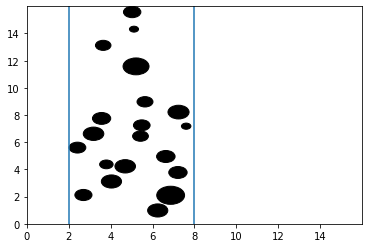

In [17]:
config = continuous_sizes(20)
draw(config)
MC_steps = 0

Number of MC steps: 169


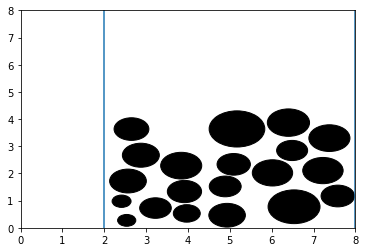

In [26]:
## test cell ## 
config = shake(config, 2)
config, cache, mc = settle(config, 2000)
MC_steps += mc
draw(config)
print("Number of MC steps:", MC_steps)

# Conic Container

In [30]:
def draw_conic(config):
    """
    Takes a configuration list and draws the corresponding arrangement of particles in a conical container
    
    Inputs
    config   List of [x, y, r, m] elements that each describe the position and size of a particle
    
    Outputs
    config   Configuration with new particle
    """
    circles = []
    
    fig, ax = plt.subplots()
    
    # y position of top of highest particle
    def get_y(x):
        return x[1]
    highest_particle = max(config, key=get_y)
    max_y_pos = max(10, highest_particle[1] + highest_particle[2])
    
    ax.set_xlim(0, max_y_pos)
    ax.set_ylim(0, max_y_pos)
    
    plt.axline((6, 0), (10, 4))
    plt.axline((6, 0), (0, 6))
    
    for particle in config:
        # Color here will give large masses a darker color
        color = str(1 - particle[3])
        circle = plt.Circle((particle[0], particle[1]), particle[2], color=color)
        ax.add_patch(circle)

In [29]:
def overlaps_conic(config, particle):
    """
    Checks whether any particle is overlapping with the boundaries of the conical container
    
    Inputs
    config     List of [x, y, r, m] elements that each describe the position and size of a particle
    xmin       Lower x boundary
    xmax       Upper x boundary
    
    Outputs
    overlaps   True or False value that indicates whether an overlap was found
    """
    x = config[particle][0]
    y = config[particle][1]
    r = config[particle][2]
    
    # Right wall
    if y < x - 6 + r*np.sqrt(2):
        return True

    # Left wall
    if y < 6 - x + r*np.sqrt(2):
        return True
    
    # Iterate over every particle except for the given one
    for i in range(len(config)):
        if i != particle:
            x1 = config[i][0]
            y1 = config[i][1]
            r1 = config[i][2]

            # Equation that checks circle overlap
            dist = np.sqrt((x - x1)**2 + (y - y1)**2)

            if dist < r1 + r:
                return True
        
    return False

In [28]:
def add_particle_conic(config, radius, mass):
    """
    Add a new particle to the configuration, accounting for relevant checks.
    
    Inputs
    config   List of [x, y, r, m] elements that each describe the position and size of a particle
    radius   Radius of particle
    mass     Mass of particle
    
    Outputs
    config   Configuration with new particle
    """
    # Chooses x and y from uniform distributions, x in [xmin, xmax] and y in [0, 10]
    y = np.random.chisquare(5,1)[0]
    xmin = 6 - y - radius*np.sqrt(2)
    xmax = y + 6 - radius*np.sqrt(2)
    x = xmin + (xmax - xmin)*np.random.rand()
    
    # While new position is not allowed, keep guessing
    while overlaps_conic(config + [[x, y, radius, mass]], len(config)):
        y = np.random.chisquare(5,1)[0]
        xmin = 6 - y - radius*np.sqrt(2)
        xmax = y + 6 - radius*np.sqrt(2)
        x = xmin + (xmax - xmin)*np.random.rand()
        
    config.append([x, y, radius, mass])
    return config

In [27]:
def continuous_sizes_conic(N):
    """
    Create initial arrangement of N particles with random size distribution
    
    Inputs
    N       Number of particles
    
    Outputs
    config  Configuration
    """
    config = []
    for _ in range(N):
        r = 0.2 + 0.5*np.random.rand()
        config = add_particle_conic(config, r, 1)
        
    return config

In [31]:
def settle_conic(config, N):
    """
    Repeatedly select particles at random and attempts jumps while recording potential at each configuration.
    Stops when change in potential is stagnant over many jumps
    
    Inputs
    N          Number of jump attempts resulting in negligible potential change
    config     List of [x, y, r, m] elements that each describe the position and size of a particle
    
    Outputs
    config     Configuration with new particle
    cache      List of configurations 
    """
    n = 0
    tol = 1
    delta = 1
    cache = []
    
    while n < N:
        particle = np.random.randint(len(config))
        old_pot = potential(config)
        config, n_jumps = jump_conic(config, particle)
        new_pot = potential(config)
        delta = np.abs(new_pot - old_pot)
            
        if delta < tol:
            n += 1
            
        cache.append(config)
            
    return config, cache

In [35]:
def jump_conic(config, particle):
    """ 
    Performs a jump for particle by finding random x and y step distances scaled by the largest nearest neighbour 
    distance. Then checks if move improves the energy and is physically allowed, then accepts the move and returns or 
    repeats until it finds an acceptable move. 
    
    Inputs
    particle         Index of the particle to perform a jump for
    config           List of [x, y, r, m] elements that each describe the position and size of a particle
    
    Outputs
    new_config       Returns a new configuration that is guaranteed to be physically allowed and improves the energy
    n                Number of attempted jumps
    """
    n = 0
    
    nndist = nn_dist(config, particle)
    
    # Break early and avoid unnecessary computations after 10 attempts
    while n < 10:
        
        new_config = np.copy(config)
        
        # Generate random x and y steps
        pot = potential(config)
        step_x = np.random.randn()*nndist/np.sqrt(2)
        step_y = np.random.randn()*nndist/np.sqrt(2)

        # Implement move and calculate new potential
        new_config[particle][0] += step_x
        new_config[particle][1] += step_y
        new_pot = potential(new_config)
        
        n += 1
        
        # Continue searching if jump is unphysical or energetically unfavourable
        if overlaps_conic(new_config, particle):
            continue
            
        elif new_pot >= pot:
            if np.exp((pot - new_pot)*1e6):
                return new_config, n
            continue
        
        # Successful jump, store information about the jump
        else:
            return new_config, n
    
    # Return unchanged config
    return config, n

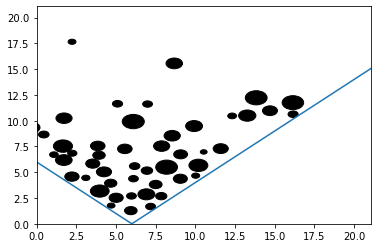

In [36]:
config = continuous_sizes_conic(50)
draw_conic(config)
configs = []

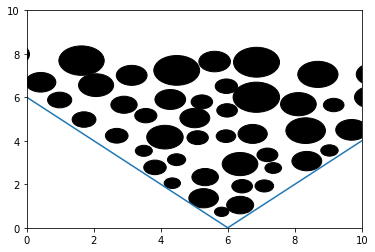

In [37]:
## test cell ##
config = shake(config, 2)
configs.append(config)
config, cache = settle_conic(config, 2000)
configs += cache
configs.append(config)
draw_conic(config)